# Zeroing in Frequency Domain is not a correct way

* [Explanation to layman on the effect of zero-ing in frequency domain](https://dsp.stackexchange.com/a/94624/73490)

> **Zeroing out a bin is the same as subtracting out a perfect sine wave of a specific bin centered frequency**. Most (or all) real world signals are imperfect (including out-of-the-bins frequency that is not multiple of ```fs/N```). If the signal you are trying to filter out is slightly different from an exactly perfect sinewave of that bin frequency, **the subtraction will leave behind a lot of "junk"**.
>
> Signals that are "between bins" are different from any (or any small subset of) basis vectors of an FFT, thus can't be removed by subtracting a basis vector, which are all perfect sine waves of bin centered frequencies, e.g. frequencies whose period is an exact integer sub-multiple of the FFT's length. The subtraction will leave behind, often nasty, "junk".

* [Why is it a bad idea to filter by zeroing out FFT bins?](https://dsp.stackexchange.com/a/6224/73490)

> **Zeroing bins in the frequency domain is the same as multiplying by a rectangular window in the frequency domain**. Multiplying by a window in the frequency domain is the same as circular convolution by the transform of that window in the time domain. The transform of a rectangular window is the Sinc function (sin(𝜔𝑡)/𝜔𝑡). Note that the Sinc function has lots of large ripples and ripples that extend the full width of time domain aperture. If a time-domain filter that can output all those ripples (ringing) is a "bad idea", then so is zeroing bins.
> 
> These ripples will be largest for any spectral content that is "between bins" or non-integer-periodic in the FFT aperture width. So if your original FFT input data is a window on any data that is somewhat non-periodic in that window (e.g. most non-synchronously sampled "real world" signals), then those particular artifacts will be produced by zero-ing bins.
> 
> Another way to look at it is that each FFT result bin represents a certain frequency of sine wave in the time domain. Thus zeroing a bin will produce the same result as subtracting that sine wave, or, equivalently, adding a sine wave of an exact FFT bin center frequency but with the opposite phase. Note that if the frequency of some content in the time domain is not purely integer periodic in the FFT width, then trying to cancel a non-integer periodic signal by adding the inverse of an exactly integer periodic sine wave will produce, not silence, but something that looks more like a "beat" note (AM modulated sine wave of a different frequency). Again, probably not what is wanted.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

In [17]:
# Parameters
fs = 5000                   # Sampling frequency
t = np.arange(-1, 1, 1/fs)  # Time vector
f_start = 10                # Start frequency of the rectangle function
f_end = 20                  # End frequency of the rectangle function

f_resolution = fs / len(t)
print(f"frequency bin resolution Δf: {f_resolution}")

frequency bin resolution Δf: 0.5


## FFT of Sinc Function is Rectangle Function in Frequency Domain 

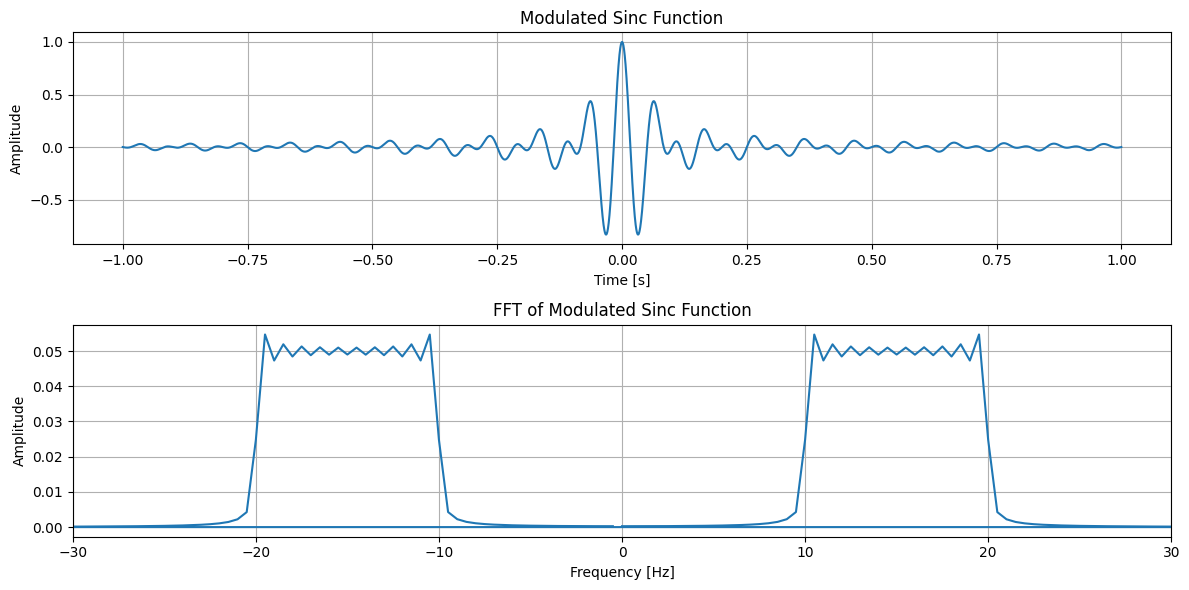

In [18]:
# Generate a sinc function centered at 0
bandwidth = f_end - f_start
# bandwidth = 10
sinc_func = np.sinc(bandwidth * t)

# Modulate sinc function to center it around the desired frequency
center_freq = (f_start + f_end) / 2
modulated_sinc = sinc_func * np.cos(2 * np.pi * center_freq * t)

# Compute the FFT of the sinc function
sinc_fft = fft(modulated_sinc)
frequencies = fftfreq(len(sinc_fft), 1/fs)

# Plotting
plt.figure(figsize=(12, 6))

# Plot sinc function
plt.subplot(2, 1, 1)
plt.grid(True)
plt.title('Modulated Sinc Function')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.plot(t, modulated_sinc)

# Plot FFT of sinc function
plt.subplot(2, 1, 2)
plt.title('FFT of Modulated Sinc Function')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
# plt.xlim(-fs/2, fs/2)  # Limit x-axis to display only meaningful part of the spectrum
plt.xlim(-30, 30)  # Limit x-axis to display only meaningful part of the spectrum
plt.grid(True)
plt.plot(frequencies, 2 * np.abs(sinc_fft) / len(sinc_fft))

plt.tight_layout()
plt.show()


## Covoluting Signal with Sinc Function is Multiply Rectangle Function in Frequency Domain

It is the same with zero-ing the magnitudes outside the bandwidth frequencies.

<StemContainer object of 3 artists>

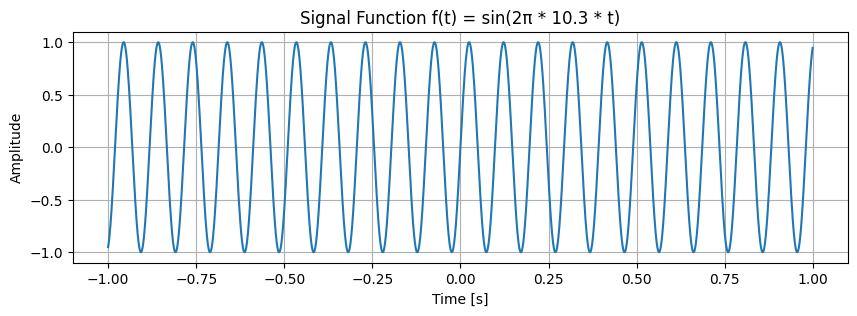

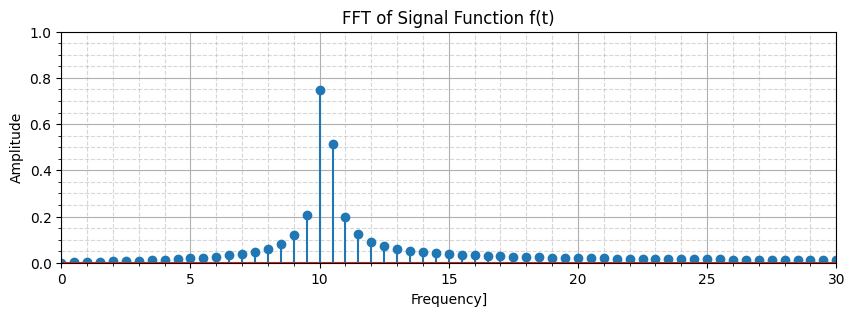

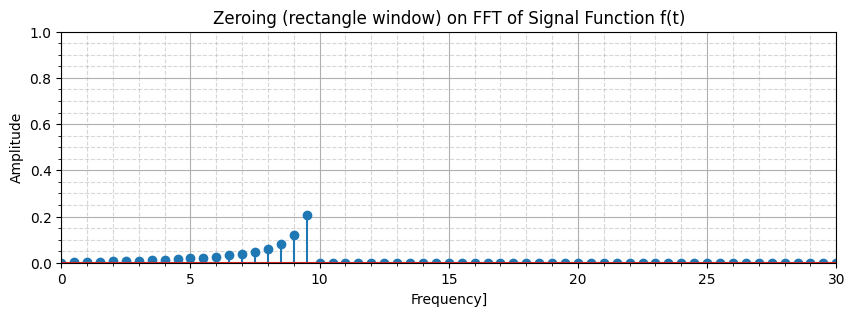

In [36]:
# Sine wave (using the 
sine_wave = np.sin(2 * np.pi * 10.2 * t) # + \
#    np.sin(2 * np.pi * 5 * t) +  \
#    np.sin(2 * np.pi * 27 * t)

# Convolution (normalize by the window function)
convolved_signal = np.convolve(sine_wave, modulated_sinc, mode='same') / np.sum(np.abs(modulated_sinc))

# Plot signal function
plt.figure(figsize=(10, 3))
# plt.subplot(3, 1, 1)
plt.plot(t, sine_wave)
plt.grid(True)
plt.title('Signal Function f(t) = sin(2π * 10.3 * t)')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

# Plot FFT of signal
plt.figure(figsize=(10, 3))
yhat = 2 * np.abs(np.fft.rfft(sine_wave, norm="forward"))
xhat = np.fft.rfftfreq(n=len(sine_wave), d=1/fs)
plt.title('FFT of Signal Function f(t)')
plt.xlabel('Frequency]')
plt.ylabel('Amplitude')
plt.ylim(0, 1.0)
plt.xlim(0, 30)
plt.grid(visible=True, which='major')
plt.grid(visible=True, which='minor', linestyle='--', alpha=0.5)
plt.minorticks_on()
plt.stem(xhat, yhat)

# Zero out bins > 10
plt.figure(figsize=(10, 3))
yhat[int(10 / f_resolution):] = 0
plt.title('Zeroing (rectangle window) on FFT of Signal Function f(t)')
plt.xlabel('Frequency]')
plt.ylabel('Amplitude')
plt.ylim(0, 1.0)
plt.xlim(0, 30)
plt.grid(visible=True, which='major')
plt.grid(visible=True, which='minor', linestyle='--', alpha=0.5)
plt.minorticks_on()
plt.stem(xhat, yhat)

# Revert

Text(0, 0.5, 'Amplitude')

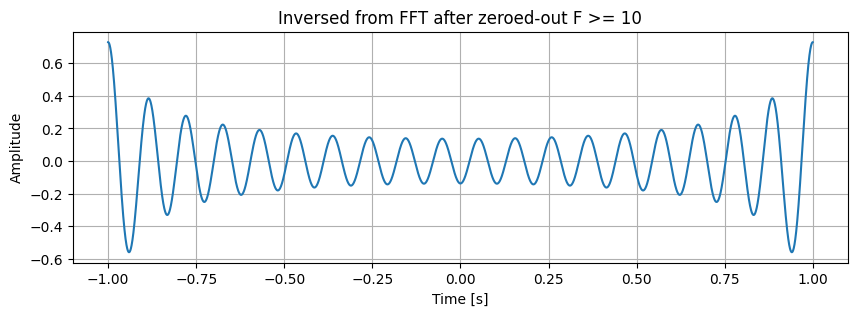

In [33]:
reverted = np.fft.irfft(yhat / 2, norm="forward")

plt.figure(figsize=(10, 3))
plt.plot(t, reverted)
plt.grid(True)
plt.title('Inversed from FFT after zeroed-out F >= 10')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')